In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from featureExtraction import load_and_extract_apertures

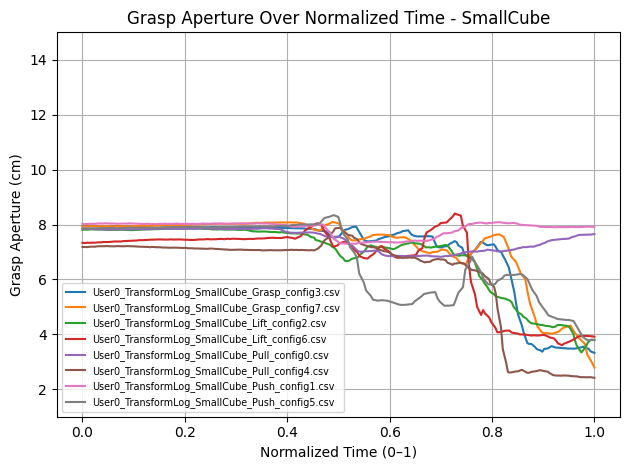

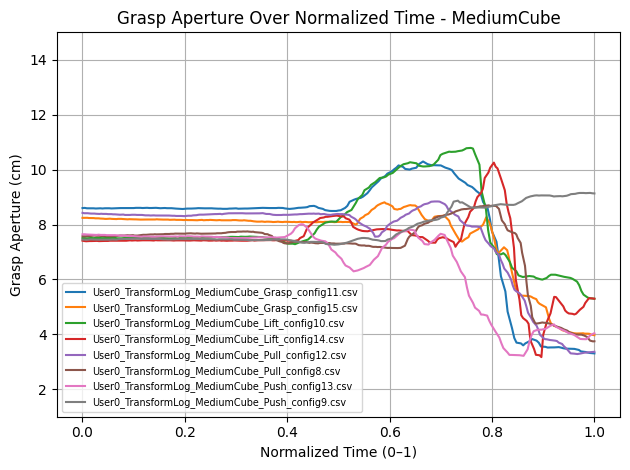

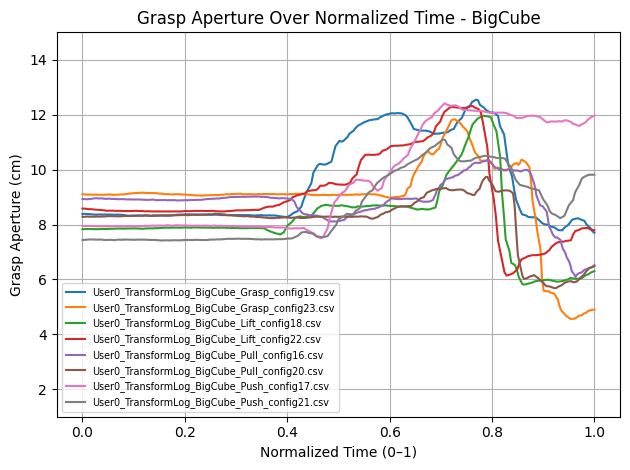

In [18]:
# Load data from processed folder
data = load_and_extract_apertures("processed/user0")

# Objects you want to visualize
objects_to_plot = ["SmallCube", "MediumCube", "BigCube"]

# Fixed y-axis range in cm
y_min, y_max = 1, 15

# Loop over each object and plot all its configs
for obj in objects_to_plot:
    subset = data[data["Object"] == obj]
    if subset.empty:
        continue

    plt.figure()
    for config_file in subset["ConfigFile"].unique():
        trial = subset[subset["ConfigFile"] == config_file].copy()

        # Normalize time to 0–1
        t_min = trial["Timestamp"].min()
        t_max = trial["Timestamp"].max()
        trial["NormalizedTime"] = (trial["Timestamp"] - t_min) / (t_max - t_min)

        # Plot aperture directly (already in cm)
        plt.plot(trial["NormalizedTime"], trial["Aperture"], label=config_file)

    plt.title(f"Grasp Aperture Over Normalized Time - {obj}")
    plt.xlabel("Normalized Time (0–1)")
    plt.ylabel("Grasp Aperture (cm)")
    plt.ylim(y_min, y_max)
    plt.legend(fontsize="x-small", loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

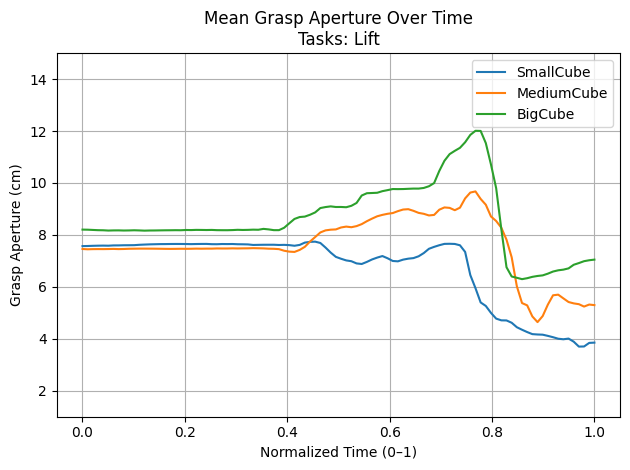

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Load preprocessed aperture data
data = load_and_extract_apertures("processed/user0")

# ✅ Customize below
objects_to_plot = ["SmallCube", "MediumCube", "BigCube"]  # Choose objects
tasks_to_include = ["Lift"]  # Choose tasks
num_points = 100  # Resample points

# Initialize result container
mean_curves = {}

for obj in objects_to_plot:
    subset = data[data["Object"] == obj]
    if subset.empty:
        continue

    # Filter by task using filename
    subset = subset[subset["ConfigFile"].apply(lambda x: any(task in x for task in tasks_to_include))]

    resampled_trials = []

    for config_file in subset["ConfigFile"].unique():
        trial = subset[subset["ConfigFile"] == config_file].copy()

        # Normalize time to 0–1
        t_min = trial["Timestamp"].min()
        t_max = trial["Timestamp"].max()
        trial["NormalizedTime"] = (trial["Timestamp"] - t_min) / (t_max - t_min)

        # Interpolate to uniform time base
        try:
            interp_func = interp1d(
                trial["NormalizedTime"], trial["Aperture"],
                kind='linear', bounds_error=False, fill_value="extrapolate"
            )
            uniform_time = np.linspace(0, 1, num_points)
            resampled_aperture = interp_func(uniform_time)
            resampled_trials.append(resampled_aperture)
        except:
            continue

    # Compute mean if valid trials exist
    if resampled_trials:
        mean_curve = np.mean(resampled_trials, axis=0)
        mean_curves[obj] = (uniform_time, mean_curve)

# ✅ Plot all mean curves on the same graph
plt.figure()
for obj, (x, y) in mean_curves.items():
    plt.plot(x, y, label=obj)

plt.title(f"Mean Grasp Aperture Over Time\nTasks: {', '.join(tasks_to_include)}")
plt.xlabel("Normalized Time (0–1)")
plt.ylabel("Grasp Aperture (cm)")
plt.ylim(1, 15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
def plot_mean_grasp_aperture_across_users(
    base_data_dir: str,
    users: list,
    objects_to_plot: list,
    tasks_to_include: list,
    num_points: int = 100,
    y_range: tuple = (1, 10),
    title: str = None,
):
    """
    Plots mean grasp aperture across multiple users for specified objects and tasks.

    Args:
        base_data_dir (str): Folder containing all user folders (e.g., 'processed').
        users (list): List of user folder names (e.g., ['user0', 'user2', ..., 'user12']).
        objects_to_plot (list): Object names to include (e.g., ['SmallCube', 'BigCube']).
        tasks_to_include (list): Task names to include (e.g., ['Grasp']).
        num_points (int): Number of time steps to interpolate per trial.
        y_range (tuple): Fixed y-axis range, e.g., (1, 10) cm.
        title (str): Optional plot title.
    """
    all_object_trials = {obj: [] for obj in objects_to_plot}

    for user in users:
        user_path = os.path.join(base_data_dir, user)
        if not os.path.exists(user_path):
            print(f"Skipping missing folder: {user_path}")
            continue

        try:
            data = load_and_extract_apertures(user_path)
        except Exception as e:
            print(f"Error loading {user_path}: {e}")
            continue

        for obj in objects_to_plot:
            subset = data[data["Object"] == obj]
            if subset.empty:
                continue

            subset = subset[subset["ConfigFile"].apply(lambda x: any(task in x for task in tasks_to_include))]

            for config_file in subset["ConfigFile"].unique():
                trial = subset[subset["ConfigFile"] == config_file].copy()

                t_min = trial["Timestamp"].min()
                t_max = trial["Timestamp"].max()
                if t_max - t_min < 0.001:
                    continue

                trial["NormalizedTime"] = (trial["Timestamp"] - t_min) / (t_max - t_min)

                try:
                    interp_func = interp1d(
                        trial["NormalizedTime"], trial["Aperture"],
                        kind='linear', bounds_error=False, fill_value="extrapolate"
                    )
                    uniform_time = np.linspace(0, 1, num_points)
                    resampled_aperture = interp_func(uniform_time)
                    all_object_trials[obj].append(resampled_aperture)
                except:
                    continue

    # Plot
    plt.figure()
    for obj, trials in all_object_trials.items():
        if not trials:
            continue
        mean_curve = np.mean(trials, axis=0)
        plt.plot(uniform_time, mean_curve, label=obj)

    final_title = title or f"Mean Grasp Aperture Across Users\nTasks: {', '.join(tasks_to_include)}"
    plt.title(final_title)
    plt.xlabel("Normalized Time (0–1)")
    plt.ylabel("Grasp Aperture (cm)")
    plt.ylim(*y_range)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


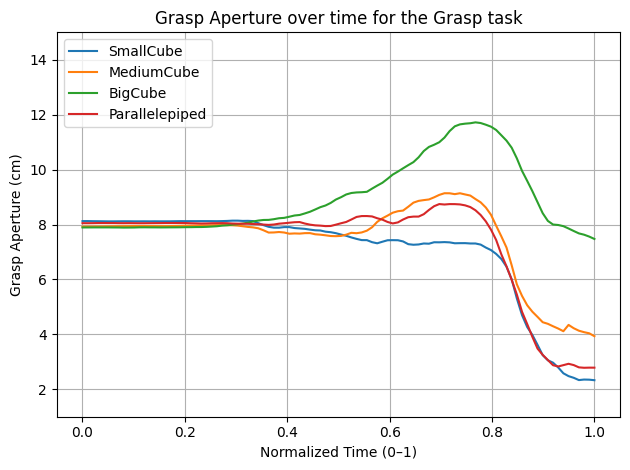

In [32]:
plot_mean_grasp_aperture_across_users(
    base_data_dir="processed",
    users=[f"user{i}" for i in range(13) if i != 1],
    objects_to_plot=["SmallCube", "MediumCube", "BigCube", "Parallelepiped"],
    tasks_to_include=["Grasp"],
    num_points=100,
    y_range=(1, 15),
    title=f"Grasp Aperture over time for the {tasks_to_include[0]} task"

)


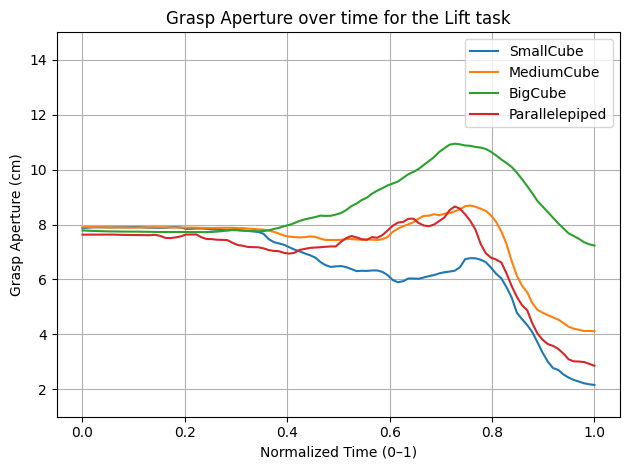

In [58]:
plot_mean_grasp_aperture_across_users(
    base_data_dir="processed",
    users=[f"user{i}" for i in range(13) if i != 1],
    objects_to_plot=["SmallCube", "MediumCube", "BigCube", "Parallelepiped"],
    tasks_to_include=["Lift"],
    num_points=100,
    y_range=(1, 15),
    title=f"Grasp Aperture over time for the Lift task"

)

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation, PillowWriter
import os

def save_hand_skeleton_animation(csv_path: str, output_dir: str = "media", fps: int = 8):
    df = pd.read_csv(csv_path)
    df = df.sort_values("Timestamp")
    timestamps = df["Timestamp"].unique()
    grouped = df.groupby("Timestamp")

    # Hand joints of interest
    hand_joints = [
        "R_Palm",
        "R_ThumbProximal", "R_ThumbDistal", "R_ThumbTip",
        "R_IndexProximal", "R_IndexIntermediate", "R_IndexTip",
        "R_MiddleProximal", "R_MiddleIntermediate", "R_MiddleTip",
        "R_RingProximal", "R_RingIntermediate", "R_RingTip",
        "R_LittleIntermediate", "R_LittleTip"
    ]

    # Bones defined as joint pairs
    bones = [
        ("R_ThumbProximal", "R_ThumbDistal"),
        ("R_ThumbDistal", "R_ThumbTip"),

        ("R_Palm", "R_IndexProximal"),
        ("R_IndexProximal", "R_IndexIntermediate"),
        ("R_IndexIntermediate", "R_IndexTip"),

        ("R_Palm", "R_MiddleProximal"),
        ("R_MiddleProximal", "R_MiddleIntermediate"),
        ("R_MiddleIntermediate", "R_MiddleTip"),

        ("R_Palm", "R_RingProximal"),
        ("R_RingProximal", "R_RingIntermediate"),
        ("R_RingIntermediate", "R_RingTip"),

        ("R_Palm", "R_LittleIntermediate"),
        ("R_LittleIntermediate", "R_LittleTip"),
    ]

    # Detect object automatically (e.g., SmallCube)
    known_extras = {"Main Camera"} | set(hand_joints)
    all_names = set(df["Name"].unique())
    possible_objects = list(all_names - known_extras)
    object_name = possible_objects[0] if possible_objects else None

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Limit data to hand + object
    df_plot = df[df["Name"].isin(hand_joints + ([object_name] if object_name else []))]

    ax.set_xlim(df_plot["PosX"].min(), df_plot["PosX"].max())
    ax.set_ylim(df_plot["PosY"].min(), df_plot["PosY"].max())
    ax.set_zlim(df_plot["PosZ"].min(), df_plot["PosZ"].max())
    ax.set_xlabel("X (cm)")
    ax.set_ylabel("Y (cm)")
    ax.set_zlabel("Z (cm)")

    # Line skeleton and scatter placeholders
    line_collection = Line3DCollection([], linewidths=2, colors='blue')
    joint_scatter = ax.scatter([], [], [], c='black', s=10)
    object_scatter = ax.scatter([], [], [], c='red', s=50)

    ax.add_collection3d(line_collection)

    def update(frame_idx):
        t = timestamps[frame_idx]
        frame = grouped.get_group(t).set_index("Name")

        # ---- Lines ----
        segments = []
        for joint_a, joint_b in bones:
            if joint_a in frame.index and joint_b in frame.index:
                pt_a = frame.loc[joint_a][["PosX", "PosY", "PosZ"]].values
                pt_b = frame.loc[joint_b][["PosX", "PosY", "PosZ"]].values
                segments.append([pt_a, pt_b])
        line_collection.set_segments(segments)

        # ---- Joints ----
        joint_coords = frame.loc[frame.index.intersection(hand_joints)][["PosX", "PosY", "PosZ"]].values
        joint_scatter._offsets3d = (joint_coords[:, 0], joint_coords[:, 1], joint_coords[:, 2])

        # ---- Object ----
        if object_name and object_name in frame.index:
            obj_pos = frame.loc[object_name][["PosX", "PosY", "PosZ"]].values
            object_scatter._offsets3d = ([obj_pos[0]], [obj_pos[1]], [obj_pos[2]])
        else:
            object_scatter._offsets3d = ([], [], [])

        ax.set_title(f"Hand Skeleton at t = {t:.2f}s")
        return [line_collection, joint_scatter, object_scatter]

    anim = FuncAnimation(fig, update, frames=len(timestamps),
                         interval=1000 / fps, blit=True)

    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.basename(csv_path).replace(".csv", ".gif")
    gif_path = os.path.join(output_dir, base_name)

    anim.save(gif_path, writer=PillowWriter(fps=fps))
    plt.close(fig)

    print(f"✅ Skeleton + Object GIF saved to: {gif_path}")
    return gif_path


In [55]:
save_hand_skeleton_animation(
    csv_path="processed/user0/User0_TransformLog_SmallCube_Grasp_config3.csv",
    fps=8
)

✅ Skeleton + Object GIF saved to: media\User0_TransformLog_SmallCube_Grasp_config3.gif


'media\\User0_TransformLog_SmallCube_Grasp_config3.gif'

In [2]:
def analyze_trial_lengths(folder: str):
    """
    Analyze durations of all transform log trials in a folder.

    Args:
        folder (str): Path to the folder containing cropped config .csv files.
    """
    durations = []

    for fname in os.listdir(folder):
        if not fname.endswith(".csv"):
            continue

        path = os.path.join(folder, fname)
        try:
            df = pd.read_csv(path)
            if "Timestamp" not in df.columns or df.empty:
                continue

            duration = df["Timestamp"].max() - df["Timestamp"].min()
            durations.append((fname, duration))
        except Exception as e:
            print(f" Failed to process {fname}: {e}")

    if not durations:
        print("No valid trials found.")
        return

    # Sort and compute stats
    durations.sort(key=lambda x: x[1])
    shortest = durations[0]
    longest = durations[-1]
    avg_duration = sum(d[1] for d in durations) / len(durations)

    print(f"📏 Shortest Trial: {shortest[0]} — {shortest[1]:.3f} seconds")
    print(f"📏 Longest Trial:  {longest[0]} — {longest[1]:.3f} seconds")
    print(f"📊 Average Trial Duration: {avg_duration:.3f} seconds over {len(durations)} trials")


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def collect_trial_data(base_folder: str = "processed") -> pd.DataFrame:
    """
    Collects trial duration statistics for each user and returns a DataFrame.
    """
    data = []

    for i in range(13):
        if i == 1:
            continue  # Skip user1 (faulty)

        user_id = f"user{i}"
        user_folder = os.path.join(base_folder, user_id)
        if not os.path.isdir(user_folder):
            print(f"{user_folder} does not exist.")
            continue

        durations = []
        for fname in os.listdir(user_folder):
            if not fname.endswith(".csv"):
                continue

            path = os.path.join(user_folder, fname)
            try:
                df = pd.read_csv(path)
                if "Timestamp" not in df.columns or df.empty:
                    continue
                duration = df["Timestamp"].max() - df["Timestamp"].min()
                durations.append(duration)
            except Exception as e:
                print(f"Failed to read {fname} in {user_folder}: {e}")

        if not durations:
            print(f"No valid trials for {user_id}")
            continue

        data.append({
            "User": user_id,
            "Shortest": min(durations),
            "Longest": max(durations),
            "Average": sum(durations) / len(durations),
            "Trials": len(durations)
        })

    return pd.DataFrame(data)



In [18]:
def plot_trial_durations(df: pd.DataFrame):
    """
    Plots the shortest, longest, and average trial durations for each user.
    """
    df = df.sort_values("User")
    x = df["User"]

    plt.figure(figsize=(14, 6))
    plt.plot(x, df["Shortest"], marker='o', label="Shortest")
    plt.plot(x, df["Longest"], marker='o', label="Longest")
    plt.plot(x, df["Average"], marker='o', label="Average")

    for i, trials in enumerate(df["Trials"]):
        plt.text(i, df["Average"].iloc[i] + 1, f"{trials} trials", ha='center', fontsize=8, color='gray')

    plt.title("Trial Durations per User")
    plt.xlabel("User")
    plt.ylabel("Duration (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


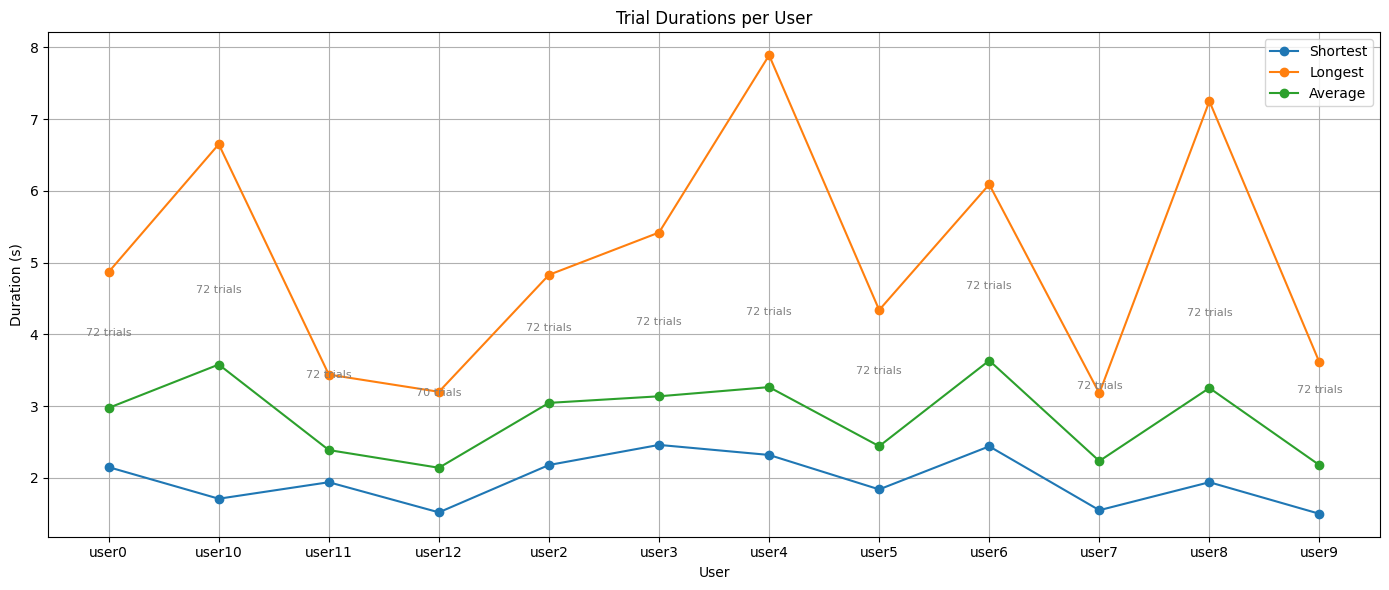

In [19]:
df = collect_trial_data("processed")
plot_trial_durations(df)

In [20]:
def analyze_all_users_trial_lengths(base_folder: str = "processed"):
    """
    Analyze trial durations for all users in the given base folder.

    Args:
        base_folder (str): The root folder containing user subfolders like 'user0', 'user2', etc.
    """
    for i in range(13):
        if i == 1:
            continue  # Skip user1 (faulty)

        user_folder = os.path.join(base_folder, f"user{i}")
        if not os.path.isdir(user_folder):
            print(f" {user_folder} does not exist.")
            continue

        durations = []
        for fname in os.listdir(user_folder):
            if not fname.endswith(".csv"):
                continue

            path = os.path.join(user_folder, fname)
            try:
                df = pd.read_csv(path)
                if "Timestamp" not in df.columns or df.empty:
                    continue
                duration = df["Timestamp"].max() - df["Timestamp"].min()
                durations.append((fname, duration))
            except Exception as e:
                print(f"Failed to read {fname} in {user_folder}: {e}")

        if not durations:
            print(f" No valid trials for user{i}")
            continue

        # Sort durations
        durations.sort(key=lambda x: x[1])
        shortest = durations[0]
        longest = durations[-1]
        avg_duration = sum(d[1] for d in durations) / len(durations)

        print(f"\n User{i}")
        print(f"  Shortest Trial: {shortest[0]} — {shortest[1]:.3f} s")
        print(f"  Longest Trial:  {longest[0]} — {longest[1]:.3f} s")
        print(f"  Average Duration: {avg_duration:.3f} s over {len(durations)} trials") 

In [21]:
analyze_all_users_trial_lengths("processed")


 User0
  Shortest Trial: User0_TransformLog_SmallCube_Grasp_config7.csv — 2.150 s
  Longest Trial:  User0_TransformLog_Hammer_Pull_config64.csv — 4.870 s
  Average Duration: 2.976 s over 72 trials

 User2
  Shortest Trial: User2_TransformLog_Parallelepiped_Lift_config26.csv — 2.180 s
  Longest Trial:  User2_TransformLog_Scissor_Push_config61.csv — 4.830 s
  Average Duration: 3.046 s over 72 trials

 User3
  Shortest Trial: User3_TransformLog_Mug_Grasp_config47.csv — 2.460 s
  Longest Trial:  User3_TransformLog_MediumCube_Pull_config8.csv — 5.420 s
  Average Duration: 3.138 s over 72 trials

 User4
  Shortest Trial: User4_TransformLog_Hammer_Push_config65.csv — 2.320 s
  Longest Trial:  User4_TransformLog_CrackerBox_Pull_config48.csv — 7.890 s
  Average Duration: 3.265 s over 72 trials

 User5
  Shortest Trial: User5_TransformLog_BigCube_Push_config21.csv — 1.840 s
  Longest Trial:  User5_TransformLog_teddy_Grasp_config39.csv — 4.340 s
  Average Duration: 2.442 s over 72 trials

 User6